In [1]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from datetime import datetime as dt
import ast
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random as random

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('checkpoint_4.csv')
df.rename(columns = {'Area (km²)': 'area_km_sq', 'Density (/km²)': 'density_km_sq'}, inplace=True)
df['resell_date'] = df['resell_date'].apply(lambda x: dt.strptime(x, "%Y-%m-%d"))
df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,lease_commence_date,storey_range,block,remaining_lease_mth,...,closest_park_dist,closest_park,num_park_1km_radius,price_per_sqm,num_of_dwellings_in_town,Region,area_km_sq,Population,density_km_sq,resell_date
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,1979.0,10 TO 12,406,736,...,1032.586022,Ang Mo Kio Town Garden East,0,5272.727273,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,1978.0,01 TO 03,108,727,...,658.451197,Ang Mo Kio Town Garden West,2,3731.343284,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,1980.0,01 TO 03,602,749,...,1111.238041,Ang Mo Kio Town Garden West,0,3910.447761,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,1980.0,04 TO 06,465,745,...,898.087299,Ang Mo Kio Town Garden East,1,3897.058824,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,1980.0,01 TO 03,601,749,...,1155.199842,Ang Mo Kio Town Garden West,0,3955.223881,61730.0,North-East,13.94,161000.0,13400.0,2017-01-01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149326 entries, 0 to 149325
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   town                      149326 non-null  object        
 1   flat_type                 149326 non-null  object        
 2   flat_model                149326 non-null  object        
 3   floor_area_sqm            149326 non-null  float64       
 4   street_name               149326 non-null  object        
 5   resale_price              149326 non-null  float64       
 6   lease_commence_date       149326 non-null  float64       
 7   storey_range              149326 non-null  object        
 8   block                     149326 non-null  object        
 9   remaining_lease_mth       149326 non-null  int64         
 10  storey_range_lower        149326 non-null  int64         
 11  address_str               149326 non-null  object        
 12  la

In [4]:
df.dropna(inplace = True)

In [5]:
categorical_variables = [
    'town', 
    'flat_type', 
    'flat_model', 
    'Region', 
    'closest_JC_sch', 
    'closest_MI_sch', 
    'closest_Uni_sch',
    'closest_Pri_sch', 'closest_Sec_sch', 'closest_mall', 'closest_park', 'closest_mrt'
    # Too many to unpack
    # 'street_name', 'block', 'address_str', 'lat_lon', 
]

numerical_variables = [
    'storey_range_lower', 
    'num_mrt_1km_radius', 
    'num_Pri_sch_1km_radius', 
    'num_Sec_sch_1km_radius',
    'num_JC_sch_1km_radius', 
    'num_MI_sch_1km_radius', 
    'num_Uni_sch_1km_radius', 
    'num_mall_1km_radius',
    'num_park_1km_radius', 
    'floor_area_sqm', 
    'closest_mrt_dist', 
    'closest_Pri_sch_dist', 
    'closest_Sec_sch_dist', 
    'closest_JC_sch_dist', 
    'closest_MI_sch_dist', 
    'closest_Uni_sch_dist',
    'closest_mall_dist', 
    'closest_park_dist', 
    'num_of_dwellings_in_town', 
    'area_km_sq', 
    'density_km_sq', 
    'Population'
]

date_variables = [
    'resell_date', 'lease_commence_date'
]

# target_variables = [
#     'price_per_sqm', 'resale_price'
# ]
# target_variable = ['resale_price']
target_variable = ['price_per_sqm']

In [6]:
unique_cts = {col: len(df[col].unique()) for col in categorical_variables}
unique_cts

{'town': 25,
 'flat_type': 7,
 'flat_model': 19,
 'Region': 5,
 'closest_JC_sch': 17,
 'closest_MI_sch': 10,
 'closest_Uni_sch': 6,
 'closest_Pri_sch': 172,
 'closest_Sec_sch': 134,
 'closest_mall': 112,
 'closest_park': 51,
 'closest_mrt': 94}

# Categorical Variables

In [7]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

binary_encoder_col = [i for i in categorical_variables if len(df[i].unique()) < 20]
target_encoder_col = [i for i in categorical_variables if len(df[i].unique()) >= 20]

# Binary Encoding
encoder= ce.BinaryEncoder(cols=binary_encoder_col,return_df=True)
bin_enc_df = encoder.fit_transform(df[binary_encoder_col]).reset_index(drop=True)

# Target Encoding
encoder = ce.TargetEncoder(cols=target_encoder_col, return_df=True, smoothing=2)
tar_enc_df = encoder.fit_transform(df[target_encoder_col], df[target_variable]).reset_index(drop=True)
scaler = StandardScaler()
tar_enc_matrix = scaler.fit_transform(tar_enc_df)
tar_enc_df_final = pd.DataFrame(tar_enc_matrix, columns = tar_enc_df.columns.values)

# Combine dfs
final_df = pd.concat([bin_enc_df, tar_enc_df_final], axis = 1)

final_df

,flat_type_0,flat_type_1,flat_type_2,flat_model_0,flat_model_1,flat_model_2,flat_model_3,flat_model_4,Region_0,Region_1,...,closest_MI_sch_3,closest_Uni_sch_0,closest_Uni_sch_1,closest_Uni_sch_2,town,closest_Pri_sch,closest_Sec_sch,closest_mall,closest_park,closest_mrt
0,0,0,1,0,0,0,0,1,0,0,...,1,0,0,1,0.122277,-0.439923,-0.073740,0.525598,0.397165,0.349307
1,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0.122277,-0.045106,0.283920,-0.314839,-0.440248,-0.295925
2,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0.122277,-0.443786,-0.416327,-0.314839,-0.440248,-0.627533
3,0,1,0,0,0,0,1,0,0,0,...,1,0,0,1,0.122277,0.365662,-0.073740,-0.391713,0.397165,0.349307
4,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0.122277,-0.443786,-0.416327,-0.314839,-0.440248,-0.627533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148079,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,-0.718311,-0.336613,-0.546548,-0.767080,-0.499968,-0.723049
148080,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,-0.718311,-0.336613,-0.433442,-0.391144,-0.499968,-0.723049
148081,1,0,1,0,0,1,0,1,1,0,...,0,0,1,1,-0.718311,-0.780449,-0.433442,-0.767080,-0.499968,-0.723049
148082,1,0,1,0,1,0,0,0,1,0,...,0,0,1,0,-0.718311,-0.645838,-0.683362,-0.761268,-1.025898,-0.405628


# Numerical Variables + Time Variables

In [8]:
scaler = StandardScaler()
num_matrix = scaler.fit_transform(df[numerical_variables + ['lease_commence_date']])
num_df = pd.DataFrame(num_matrix, columns = numerical_variables + ['lease_commence_date'])

In [9]:
final_df = pd.concat([final_df, num_df], axis = 1)

# Train test split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df, df[target_variable], test_size=0.33, random_state=42, shuffle=True)

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(99216, 52) (48868, 52) (99216, 1) (48868, 1)


# XGBoost (with hyperopt tuning)

In [12]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

In [13]:
# Hyperparameter tuning space
space = {
    'max_depth': hp.quniform("max_depth", 3, 26, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 160, 280, 10),
    }

# Objective function for regression: 
def hyperparameter_tuning(space):
    
    # Initialise model
    model = xgb.XGBRegressor(
        n_estimators =int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=space['min_child_weight'],
        colsample_bytree=space['colsample_bytree']
        )
  
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(
        X_train, 
        y_train,
        eval_set=evaluation, 
        eval_metric="rmse",
        early_stopping_rounds=10,
        verbose=False
    )

    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    print (f"VAL_SCORE (MSE): {mse}")
    return {'loss':mse, 'status': STATUS_OK, 'model': model}

# Run trials
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
    )

print (best)

VAL_SCORE (MSE): 247969.80369723716                   
VAL_SCORE (MSE): 253953.92138507176                                             
VAL_SCORE (MSE): 265843.26254075166                                             
VAL_SCORE (MSE): 259469.66617775487                                             
VAL_SCORE (MSE): 253724.070168119                                               
VAL_SCORE (MSE): 250601.2999298127                                              
VAL_SCORE (MSE): 264951.99282783165                                             
VAL_SCORE (MSE): 263988.1234131302                                              
VAL_SCORE (MSE): 269388.9321557625                                              
VAL_SCORE (MSE): 247008.6706284795                                              
VAL_SCORE (MSE): 272936.64564243605                                             
VAL_SCORE (MSE): 248554.2026647933                                              
VAL_SCORE (MSE): 276741.764371362                     

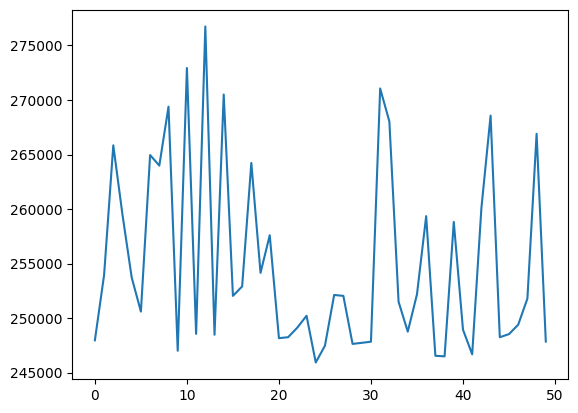

In [14]:
# trials.trials
# trials.results
plt.plot(trials.losses())
plt.show()

In [15]:
best_model = xgb.XGBRegressor(
    colsample_bytree = best['colsample_bytree'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = int(best['min_child_weight']),
    reg_alpha = int(best['reg_alpha']),
    reg_lambda = best['reg_lambda'],
    n_estimators = int(best['n_estimators'])
    )

In [16]:
best_model.fit(
    X_train,
    y_train
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6698015698568416, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.611640483766763, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [17]:
pred = best_model.predict(X_test)
mse= mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
print (f"MSE:{mse}\nRMSE:{rmse}")

MSE:247102.41299476265
RMSE:497.0939679726185


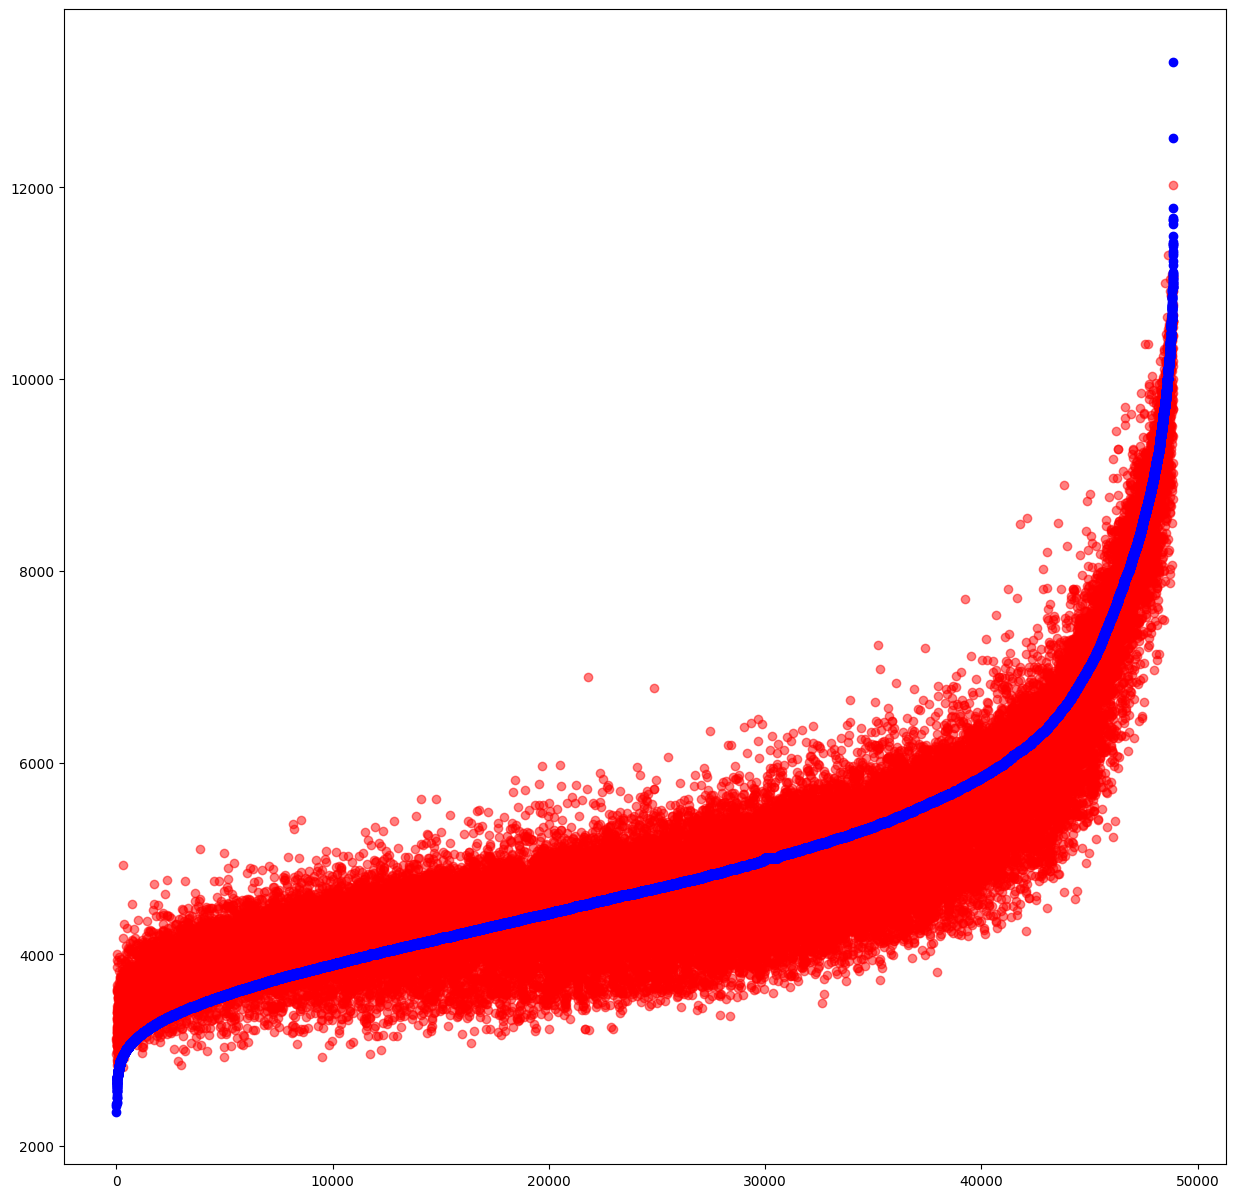

In [18]:
results = pd.DataFrame({'actual': y_test.iloc[:,0].values, 'pred': pred})
results = results.sort_values(['actual'])
results = results.reset_index(drop=True)

plt.figure(figsize=(15,15))
plt.scatter(x = results.index, y = results['pred'], alpha = 0.5, color = 'r')
plt.scatter(x = results.index, y = results['actual'], color = 'b')
plt.show()

In [19]:
# Save model to JSON
best_model.save_model("xgb_model.json")

In [20]:
# Load model
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("xgb_model.json")